<a href="https://colab.research.google.com/github/newgabo/TP2-AA/blob/master/TP2_AA_Modelos_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import's

In [ ]:
from io import BytesIO

import pickle
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import librosa
import glob

from IPython.display import Audio

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Notación Científica a Decimal
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Features

In [ ]:
# Desde nuestro repo!
github_Link_ = 'https://github.com/newgabo/TP2-AA/blob/master/feat_numbers.p?raw=true'
file_ = BytesIO(requests.get(github_Link_).content)
df_features = pickle.load(file_)

df_features.shape

(23666, 81)

In [ ]:
df_features.head(3)

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file,group
0,-447.013,82.107,30.129,37.495,26.410,19.350,0.221,13.787,-2.091,10.187,-7.550,10.406,0.020,105.243,66.167,31.379,17.045,16.423,8.988,9.500,9.900,9.094,6.358,9.571,5.839,0.020,2.496,2.679,1.383,0.637,0.353,-0.075,-0.396,0.066,0.210,0.001,-0.285,-0.135,0.000,30.678,...,16.547,10.995,9.366,8.321,6.260,6.316,6.087,5.225,6.299,4.700,0.005,-0.892,-0.599,-0.008,0.031,0.060,0.012,-0.036,-0.154,0.044,0.055,-0.319,-0.205,0.000,27.638,17.219,17.457,12.668,12.201,9.885,6.972,6.423,8.006,6.841,7.951,6.087,0.004,zero,zero/b087aa0e_nohash_3.wav,train
1,-467.465,106.486,-15.164,-15.917,-14.514,-0.944,-22.115,-2.099,-15.078,-5.340,-2.508,-4.010,0.014,143.691,70.236,41.396,40.315,12.078,11.623,22.693,9.660,21.297,13.317,17.372,9.551,0.016,-7.602,0.237,0.089,-2.493,-0.741,-1.250,-0.836,-0.696,0.170,0.122,0.354,-0.369,-0.000,39.752,...,20.763,13.505,7.302,7.357,9.344,5.286,8.008,7.524,8.351,6.591,0.004,1.047,0.668,0.701,0.556,0.056,0.025,-0.053,0.377,0.467,-0.151,-0.275,-0.094,0.000,26.817,19.741,18.224,13.531,8.567,8.785,10.018,5.970,7.915,9.536,8.486,7.919,0.002,zero,zero/1a892463_nohash_1.wav,train
2,-387.342,103.399,19.127,14.151,4.236,2.917,-8.341,-4.872,0.061,-0.831,-3.717,2.288,0.012,64.781,35.180,33.912,21.784,12.908,6.430,16.484,13.219,10.295,8.538,6.550,5.132,0.008,-0.206,0.652,-0.220,0.448,-0.305,-0.063,-0.035,-0.006,-0.274,-0.224,-0.302,-0.081,-0.000,22.896,...,13.690,14.482,9.327,5.372,8.143,6.306,7.962,4.619,3.983,4.335,0.002,-0.037,-0.071,0.117,-0.118,-0.021,0.003,-0.007,0.066,0.037,0.016,-0.083,-0.235,0.000,21.680,12.490,10.517,13.018,10.620,6.833,9.695,7.443,8.834,4.592,4.575,5.141,0.002,zero,zero/fb2f3242_nohash_0.wav,train


In [ ]:
# Algunos controles para yo entender la data nuevamente
df_features.groupby('target').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,group
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
eight,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352
five,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357
four,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372
nine,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364
one,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370
seven,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377
six,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369
three,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,235

In [ ]:
df_features.groupby('group').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
testing,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552
train,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620
validation,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494


# Modelos

In [ ]:
df_train = df_features[df_features['group'] == 'train']

del df_train['group']
del df_train['file']
len(df_train.index)

18620

In [ ]:
features = df_train.loc[:, df_train.columns != 'target'].columns
target = 'target'

x_train, y_train = df_train[features].values, df_train[target].values

In [ ]:
df_test = df_features[df_features['group'] == 'testing']

del df_test['group']
del df_test['file']
len(df_test.index)

2552

In [ ]:
x_test, y_test = df_test[features].values, df_test[target].values

### Bagging Parameters


*   n_estimators
*   max_features
*   oob_score

### Tree-specific Parameters


*   max_depth
*   min_samples_split
*   min_samples_leaf
*   class_weight (balanced)



### Naive Bayes

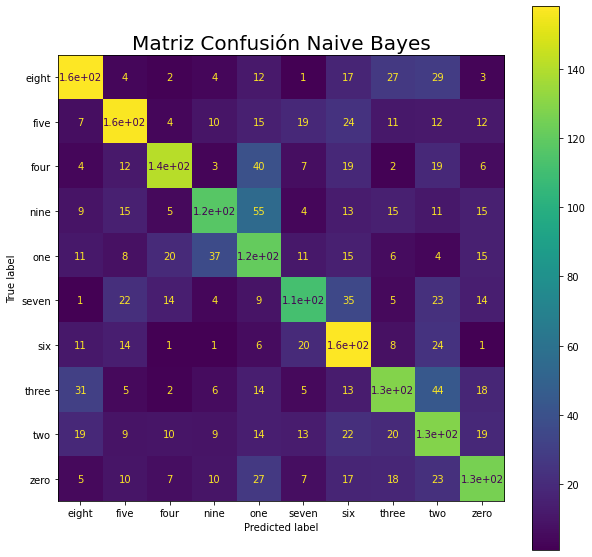

Accuracy Training : 0.541
Accuracy Test: 0.528


In [ ]:
clf_nb_ = GaussianNB()
clf_nb_.fit(x_train, y_train)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_nb_, x_test, y_test, ax = ax)
plt.title("Matriz Confusión Naive Bayes", size=20)
plt.show()

print("Accuracy Training : {:.3f}".format(clf_nb_.score(x_train, y_train)))
print("Accuracy Test: {:.3f}".format(clf_nb_.score(x_test, y_test)))

### Random Forest

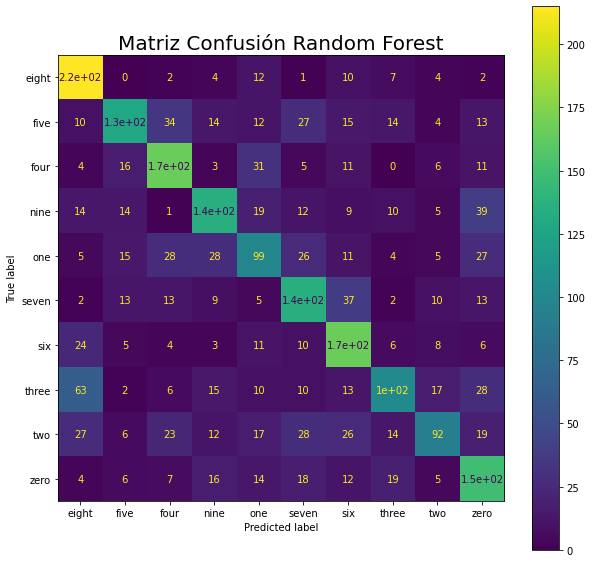

Accuracy training : 0.596
Accuracy test: 0.545
Best Random Forest Score 0.572 with params {'bootstrap': True, 'max_depth': 5, 'max_features': 6, 'n_estimators': 100}


In [ ]:
parameters = {'n_estimators':range(100, 200, 500), 'max_depth':range(5,10,15), 'bootstrap':[True, False], 'max_features': [6, 8, 10]}
clf_rf_ = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, scoring='accuracy')
clf_rf_.fit(x_train, y_train)

clf_rf_be_ = clf_rf_.best_estimator_
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_rf_be_, x_test, y_test, ax = ax)
plt.title("Matriz Confusión Random Forest", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_rf_be_.score(x_train, y_train)))
print("Accuracy test: {:.3f}".format(clf_rf_be_.score(x_test, y_test)))
print("Best Random Forest Score {0:.3f} with params {1}".format(clf_rf_.best_score_, clf_rf_.best_params_))

### Gradient Boosting 

1.   Initial Model (weak estimator)
2.   New Model fits to residuals
3.   New additive model
4.   Repeat n times or until error is small enough
5.   Final additive model

A diferencia de los modelos por Votación, en Gradient Boosting los estimadores no se combinan mediante votación o promedios, sino por suma. Se debe a que el primer modelo se ajusta a la variable objetivo y el resto son estimaciones de los errores residuales.

Parámetros:
*   n_estimators
*   learning_rate
*   max_depth
*   min_samples_split
*   min_samples_leaf
*   max_features

En Gradient Boosting se recomiendan utilizar todos los parámetros.

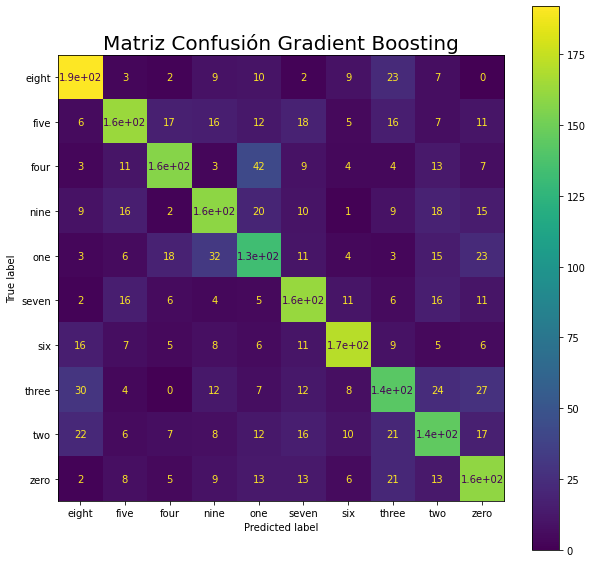

Accuracy training : 0.875
Accuracy test: 0.621
Best Gradient Boosting Score 0.643 with params {'learning_rate': 0.01, 'max_depth': 8, 'max_features': 10, 'n_estimators': 10}


In [ ]:
"""
parameters = {'n_estimators':range(100, 200), 'learning_rate': np.linspace(0 ,0.1), 'max_features': [6, 8, 10], 
              'n_iter_no_change': [5], 'tol': [0.01]} 

parameters = {'n_estimators':range(100, 200), 
              'learning_rate': [0 ,0.1], 
              'n_iter_no_change': [5], 'tol': [0.01]}    
"""
     
parameters = {
    "learning_rate": [0, 0.01],
    "max_depth":[3,5,8],
    'max_features': [6, 8, 10],
    "n_estimators":[10]
    }          
clf_gb_ = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=10, scoring='accuracy')
clf_gb_.fit(x_train, y_train)

clf_gb_be_ = clf_gb_.best_estimator_
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_gb_, x_test, y_test, ax = ax)
plt.title("Matriz Confusión Gradient Boosting", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_gb_.score(x_train, y_train)))
print("Accuracy test: {:.3f}".format(clf_gb_.score(x_test, y_test)))
print("Best Gradient Boosting Score {0:.3f} with params {1}".format(clf_gb_.best_score_, clf_gb_.best_params_))

### Multilayer Perceptron

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


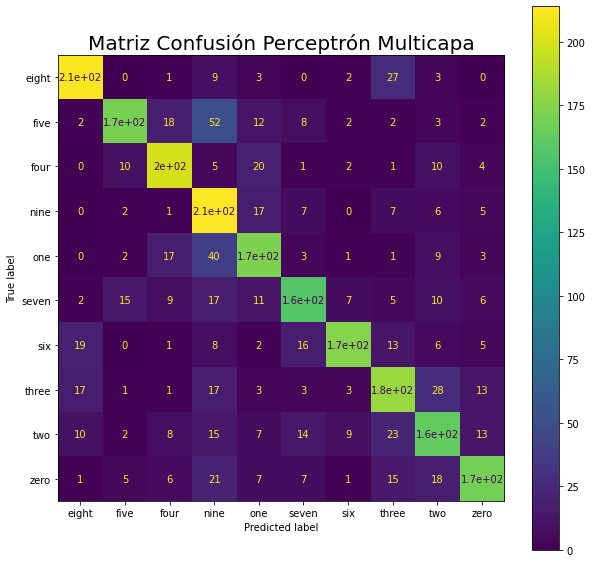

Accuracy training : 0.833
Accuracy test: 0.710
Best Multilayer Perceptron Score 0.765 with params {'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
    
}

clf_mlp_ = GridSearchCV(MLPClassifier(max_iter=100), parameter_space, n_jobs=-1, scoring='accuracy')
clf_mlp_.fit(x_train, y_train)

clf_mlp_be_ = clf_mlp_.best_estimator_

# En el TP se menciona lo siguiente:
# Elegir el numero de neuronas de la capa utilizando Random Search
# por lo tanto, deberíamos hacer uso de RandomizedSearchCV()? Yo venía haciendo uso de GridSearch()
#
# Qué opinan?

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_mlp_, x_test, y_test, ax = ax)
plt.title("Matriz Confusión Perceptrón Multicapa", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_mlp_.score(x_train, y_train)))
print("Accuracy test: {:.3f}".format(clf_mlp_.score(x_test, y_test)))
print("Best Multilayer Perceptron Score {0:.3f} with params {1}".format(clf_mlp_.best_score_, clf_mlp_.best_params_))

# Comparación performance

Text(0.5, 1.0, 'Comparación Modelos: Train&Test Performance')

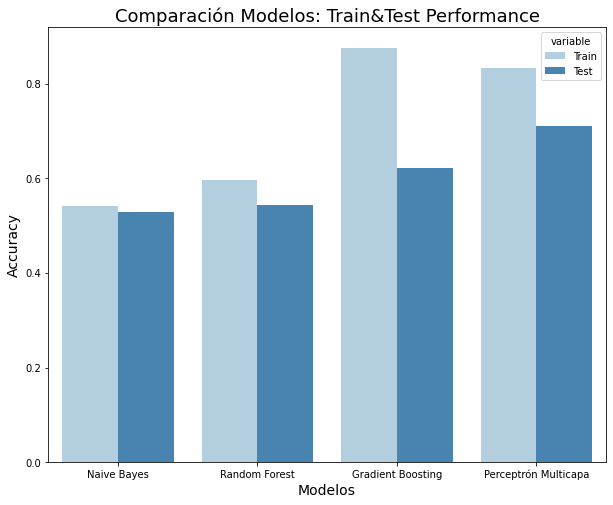

In [ ]:
dict_performance_ = {'Modelo': ['Naive Bayes', 'Random Forest', 'Gradient Boosting', 'Perceptrón Multicapa'], 
     'Train': [clf_nb_.score(x_train, y_train), 
               clf_rf_be_.score(x_train, y_train),
               clf_gb_.score(x_train, y_train),
               clf_mlp_.score(x_train, y_train)
               ], 
     'Test':  [clf_nb_.score(x_test, y_test),
               clf_rf_be_.score(x_test, y_test),
               clf_gb_.score(x_test, y_test),
               clf_mlp_.score(x_test, y_test)
               ]}
df_performance_ = pd.DataFrame(data=dict_performance_)

plt.figure(figsize=(10, 8))
sns.barplot(x="Modelo", y="value", hue="variable", data=pd.melt(df_performance_, id_vars=['Modelo']), palette="Blues")
plt.ylabel("Accuracy", size=14)
plt.xlabel("Modelos", size=14)
plt.title("Comparación Modelos: Train&Test Performance", size=18)

# Evaluación de Ruido

Comienzo por Instalar .rar para descomprimir los archivos de validación

In [ ]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 1s (511 kB/s)
Selecting previously unselected package rar.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
#!mkdir validation
!unrar x "/content/sample_data/Validation.rar" "/content/validation/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/sample_data/Validation.rar

Creating    /content/validation/Validation                            OK
Creating    /content/validation/Validation/eight                      OK
Extracting  /content/validation/Validation/eight/060cd039_nohash_0.wav       0%  OK 
Extracting  /content/validation/Validation/eight/099d52ad_nohash_0.wav       0%  OK 
Extracting  /content/validation/Validation/eight/099d52ad_nohash_1.wav       0%  OK 
Extracting  /content/validation/Validation/eight/099d52ad_nohash_2.wav       0%  OK 
Extracting  /content/validation/Validation/eight/099d52ad_nohash_3.wav       0%  OK 
Extracting  /content/validation/Validation/eight/099d52ad_nohash_4.wav       0%  OK 
Extracting  /content/validation/Validation/eight/0ab3b47d_nohash_0.wav       0%  OK 
Extracting  /content/validation/Validation/eight/0ab3b47d_nohash_1.wav    

In [ ]:
#!wget https://github.com/newgabo/TP2-AA/blob/master/validation/Validation0a4.rar
#!wget https://github.com/newgabo/TP2-AA/blob/master/validation/Validation5a9.rar

#!mkdir validation

In [ ]:
# from https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real
    

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

In [ ]:
audio_numero = "/content/validation/Validation/eight/471a0925_nohash_0.wav"
x, fs = librosa.core.load(audio_numero, sr=None)
Audio(x, rate=fs)

In [ ]:
import numpy as np

t = np.linspace(0,1,44100)
audio = np.sin(1200*t)

ruido = np.random.normal(size=audio.shape)
senal = ruido + audio

Audio(senal, rate=44100)

In [ ]:
import numpy as np

t = np.linspace(0,1,16000)
audio = np.sin(1200*t)

ruido = np.random.normal(size=audio.shape)
senal = ruido + audio

Audio(senal, rate=16000)

In [ ]:
# A lo bruto...
audio_con_ruido = audio + x

#audio_con_ruido = x[5000:5000+len(senal)]
#result = x + senal
#Audio(x + audio)
#Audio(audio_con_ruido, rate=16000)
#Audio(audio_con_ruido)

Audio(audio_con_ruido, rate=44100)

In [ ]:
# Generación de Ruido

noise_len = 2 # seconds
noise = band_limited_noise(min_freq=4000, max_freq = 12000, samples=len(x), samplerate=fs)*10
noise_clip = noise[:fs*noise_len]
audio_con_ruido = x+noise

Audio(data=audio_con_ruido, rate=fs)

In [ ]:
senal.shape

(16000,)

In [ ]:
x.shape

(16000,)

In [ ]:
audio.shape

(16000,)

A partir de acá comienzo a armar la función que va a ir agregando ruido a la porción de Validación...


In [ ]:
# Definicipn de Niveles de Ruido
noise_levels_ = np.arange(0.0, 0.2, 0.02)
noise_levels_

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18])

Primero corro los mejores modelos para los datos de Evaluación originales...

In [ ]:
df_validation = df_features[df_features['group'] == 'validation']

del df_validation['group']
del df_validation['file']

x_validation, y_validation = df_validation[features].values, df_validation[target].values

In [ ]:
modelos = [('Naive Bayes', 0), ('Random Forest', 0), ('Gradient Boosting', 0), ('Multilayer Perceptron', 0)]
acc_validation = {} # Voy a armar un diccionario
for noise in noise_levels_:
  for modelo in modelos:
    print(modelo, noise)
  #acc_validation[modelo[0]] = {} # Sobre el cual voy a ir guardando los modelos con su nivel de ruido
  #acc_validation[modelo[0]]['0'] = modelo[1].score(x_validation, y_validation) # Primero el acc para nivel 0 de ruido
  #acc_validation[modelo[0]]['0.1'] = modelo[1].score(x_validation, y_validation) # Ejemplo de como quedaria agregando ruido

('Naive Bayes', 0) 0.0
('Naive Bayes', 0) 0.02
('Naive Bayes', 0) 0.04
('Naive Bayes', 0) 0.06
('Naive Bayes', 0) 0.08
('Naive Bayes', 0) 0.1
('Naive Bayes', 0) 0.12
('Naive Bayes', 0) 0.14
('Naive Bayes', 0) 0.16
('Naive Bayes', 0) 0.18
('Random Forest', 0) 0.0
('Random Forest', 0) 0.02
('Random Forest', 0) 0.04
('Random Forest', 0) 0.06
('Random Forest', 0) 0.08
('Random Forest', 0) 0.1
('Random Forest', 0) 0.12
('Random Forest', 0) 0.14
('Random Forest', 0) 0.16
('Random Forest', 0) 0.18
('Gradient Boosting', 0) 0.0
('Gradient Boosting', 0) 0.02
('Gradient Boosting', 0) 0.04
('Gradient Boosting', 0) 0.06
('Gradient Boosting', 0) 0.08
('Gradient Boosting', 0) 0.1
('Gradient Boosting', 0) 0.12
('Gradient Boosting', 0) 0.14
('Gradient Boosting', 0) 0.16
('Gradient Boosting', 0) 0.18
('Multilayer Perceptron', 0) 0.0
('Multilayer Perceptron', 0) 0.02
('Multilayer Perceptron', 0) 0.04
('Multilayer Perceptron', 0) 0.06
('Multilayer Perceptron', 0) 0.08
('Multilayer Perceptron', 0) 0.1
('Mu

In [ ]:
def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  
  return summary_features, feat_names

# Lista de Audios de Validación
zero_wavs = glob.glob('/content/validation/Validation/zero/*.wav')
one_wavs = glob.glob('/content/validation/Validation/one/*.wav')
two_wavs = glob.glob('/content/validation/Validation/two/*.wav')
three_wavs = glob.glob('/content/validation/Validation/three/*.wav')
four_wavs = glob.glob('/content/validation/Validation/four/*.wav')
five_wavs = glob.glob('/content/validation/Validation/five/*.wav')
six_wavs = glob.glob('/content/validation/Validation/six/*.wav')
seven_wavs = glob.glob('/content/validation/Validation/seven/*.wav')
eight_wavs = glob.glob('/content/validation/Validation/eight/*.wav')
nine_wavs = glob.glob('/content/validation/Validation/nine/*.wav')

vec_num = [['zero',zero_wavs],
          ['one',one_wavs],
          ['two',two_wavs], 
          ['three',three_wavs],
          ['four',four_wavs],
          ['five', five_wavs], 
          ['six', six_wavs],
          ['seven',seven_wavs],
          ['eight',eight_wavs],
          ['nine',nine_wavs]]

In [ ]:
df_all=pd.DataFrame()

for numero in vec_num:
  
  print(numero[0])
  print(len(numero[1]))
  #for arch in numero[1]:



zero
260
one
230
two
236
three
248
four
280
five
242
six
262
seven
263
eight
243
nine
230


In [ ]:
features = df_train.loc[:, df_train.columns != 'target'].columns
target = 'target'

x_train, y_train = df_train[features].values, df_train[target].values

In [ ]:
df_validation = df_features[df_features['group'] == 'validation']

del df_validation['group']
del df_validation['file']

x_validation, y_validation = df_validation[features].values, df_validation[target].values

In [ ]:
modelos = [('Naive Bayes', 0), ('Random Forest', 0), ('Gradient Boosting', 0), ('Multilayer Perceptron', 0)]
acc_validation = {} # Voy a armar un diccionario
for modelo in modelos:
  for noise in noise_levels_:
    print(modelo, noise)